In [1]:
import os
import json

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def group_best_params_with_stop(df, group_num, stop_iter_num, group_size = 243):
    best_params = {}
    stop_iter_nums = {}
    best_score = {}

    tmp_df = df.loc[(df['iter_num'] > (group_num-1)*group_size) & \
                        (df['iter_num'] <= group_num*group_size)].copy() #take group
    
    for i in tmp_df.run_number.unique(): 
        tmp_df_i = tmp_df.loc[tmp_df.run_number==i] #take run
        #cut iterations:
        tmp_df_i_copy = tmp_df_i.copy()
        tmp_df_i_copy.loc[:, "mean_test_score"] = \
            tmp_df_i.loc[:, "mean_test_score"].cummax()      

        try:
            curr_max=tmp_df_i_copy.groupby("mean_test_score")["mean_test_score"]\
                .count().reset_index()
            max_score = curr_max.loc[curr_max["mean_test_score"]\
                                     >=stop_iter_num].index[0] 
                #get first interval with iter_amount more than stop_iter_num
        except:
            max_score = tmp_df_i_copy.mean_test_score.max()

        tmp_stop = tmp_df_i.loc[tmp_df_i["mean_test_score"]\
                                ==max_score].sort_values(by="iter_num").iloc[0]
            #get first element with best_score

        best_params[i] = tmp_stop['params']
        best_score[i] = max_score

        last_iter_num = tmp_stop['iter_num'] + stop_iter_num-1
        if (last_iter_num > group_num*group_size):
            last_iter_num = group_num*group_size

        stop_iter_nums[i] = last_iter_num - group_size*(group_num-1)
    return best_params, stop_iter_nums, best_score    

def get_df_from_files(files_arr, group_num, group_size = 243):
    if group_num == 1:
        file_dir = "../data/results/test 1/"
    else:
        file_dir = "../data/results/test 2/"

    group_df = pd.DataFrame([])
    for file_name in files_arr:
        file_df = pd.read_csv(file_dir + file_name, 
                              usecols = ['mean_test_score',
                                         'params','run_number'])
        file_df['iter_num'] = range(1, file_df.shape[0]+1) 
        file_df['iter_num'] += (group_num-1)*group_size
        group_df = pd.concat([group_df, file_df], sort = False)
    return group_df
    

In [3]:
first_group_files=os.listdir("../data/results/test 1")
grid_files = [x for x in first_group_files if "grid" in x]
random_search_files = [x for x in first_group_files if x.find("random")!=-1]
first_group_files = [x for x in first_group_files if x.find("group")!=-1]
sec_and_third_group_files_dir=os.listdir("../data/results/test 2")

In [4]:
grid_df=pd.DataFrame([])
for file_name in grid_files:
    df = pd.read_csv("../data/results/test 1/"+file_name, usecols = ['experiment_name',
                                                                     'mean_test_score',
                                         'params'])
    
    df['iter_num']=1
    df.loc[df['experiment_name']!='default params', 
           'iter_num'] = range(1, df.loc[df['experiment_name']!='default params'].shape[0]+1)
    
    grid_df = pd.concat([grid_df, df], sort=False)
    
random_df = pd.DataFrame([])
for file_name in random_search_files:
    file_df = pd.read_csv("../data/results/test 1/" + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'params','run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    random_df = pd.concat([random_df, file_df], sort = False)

In [5]:
iters_info = {}
scores_info = {}

In [78]:
stop_iter_num = 50

In [79]:
sec_and_third_group_files = [x for x in sec_and_third_group_files_dir \
                                 if x.find(str(stop_iter_num))!=-1]

In [80]:
best_params_full = {}
stop_iter_nums_full = {}
best_score_full = {}

In [81]:
first_df = get_df_from_files(first_group_files, 1)
first_df = first_df.loc[first_df.iter_num<244]
best_params_full[1], stop_iter_nums_full[1], best_score_full[1] = \
            group_best_params_with_stop(first_df, 1, stop_iter_num)

gr_2_and_3_df = get_df_from_files(sec_and_third_group_files, 2)
best_params_full[2], stop_iter_nums_full[2], best_score_full[2] = \
            group_best_params_with_stop(gr_2_and_3_df, 2, stop_iter_num)
best_params_full[3], stop_iter_nums_full[3], best_score_full[3] = \
            group_best_params_with_stop(gr_2_and_3_df, 3, stop_iter_num)

In [82]:
full_df = pd.concat([first_df, gr_2_and_3_df], sort = False)

In [83]:
scores = np.array(list(best_score_full[3].values()), dtype = float)
print("MEAN best score:", np.mean(scores))
print("STD best score:", np.std(scores))

MEAN best score: 0.6663082716758508
STD best score: 0.0010631944516123837


In [84]:
scores_info['GRS_'+str(stop_iter_num)] = {'mean':np.mean(scores), 'std': np.std(scores)}

In [85]:
for group_num in best_params_full:
    params_set = []
    for run_num in best_params_full[group_num]:
        param_vals = json.loads((best_params_full[group_num][run_num]).replace("\'","\""))
        params_set.append(list(param_vals.values()))
    print("Group num: ", group_num)
    print("Mean: ",np.mean(params_set, axis = 0))
    print("Std: ",np.std(params_set, axis = 0))

Group num:  1
Mean:  [5. 9.]
Std:  [0. 0.]
Group num:  2
Mean:  [0.42981767 0.57238993]
Std:  [0.24265102 0.2644884 ]
Group num:  3
Mean:  [0.7048306  0.78385028]
Std:  [0.12789717 0.06681897]


In [86]:
for group_num in stop_iter_nums_full:
    for run_num in stop_iter_nums_full[group_num]:
        stop_num = stop_iter_nums_full[group_num][run_num]
        full_df.loc[(full_df.run_number == run_num)&\
                    (full_df.iter_num > (group_num-1)*243)&\
                   (full_df.iter_num <= group_num*243)] = full_df.loc[(full_df.run_number == run_num)&\
                        (full_df.iter_num > (group_num-1)*243)&\
                        (full_df.iter_num <= (group_num-1)*243 + stop_num)]


In [87]:
full_df = full_df.dropna(how = 'all')

In [88]:
max_iters = []
for run_num in full_df.run_number.unique():
    max_iters.append(full_df.loc[full_df.run_number == run_num].shape[0])
    full_df.loc[full_df.run_number == run_num, 'iter_num'] = range(1, max_iters[-1]+1)
print("MEAN iters num:", np.mean(max_iters))
print("STD iters num:", np.std(max_iters))

MEAN iters num: 298.8
STD iters num: 76.77343290487927


In [89]:
iters_info['GRS_'+str(stop_iter_num)] = {'mean':np.mean(max_iters), 'std': np.std(max_iters)}

In [90]:
max_iter = np.max(max_iters)

In [91]:
max_score_and_iter = full_df.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()

In [92]:
full_df = full_df.loc[:, ['mean_test_score', 'iter_num', 'run_number']]

In [93]:
for run_number in list(max_score_and_iter.loc[
        max_score_and_iter.iter_num < max_iter].index):
    new_part_df = pd.DataFrame([], columns=full_df.columns )
    new_part_df['iter_num']=range(int(max_score_and_iter.loc[run_number, 'iter_num']+1), 
                                  int(max_iter)+1)
    new_part_df['run_number'] = run_number
    new_part_df['mean_test_score'] = full_df.loc[full_df.run_number == run_number, 'mean_test_score'].max()
    full_df = pd.concat([full_df, new_part_df])
    full_df.loc[full_df.run_number == run_number, 'mean_test_score'] = \
        full_df.loc[full_df.run_number == run_number, 'mean_test_score'].cummax()
    
for run_number in list(max_score_and_iter.loc[
        max_score_and_iter.iter_num >= max_iter].index):
    full_df.loc[full_df.run_number == run_number, 'mean_test_score'] = \
        full_df.loc[full_df.run_number == run_number, 'mean_test_score'].cummax()

In [94]:
full_df['experiment_name']='group search'

In [95]:
## RANDOM_SEARCH
#get best scores per itration for each random_search performance:
random_df_stopped=pd.DataFrame([])
max_iters_for_RS = []
for i in random_df.run_number.unique():
    
    tmp=pd.DataFrame(random_df.loc[random_df.run_number==i, 
                                   "mean_test_score"].copy().cummax())
    tmp["iter_num"]=random_df.loc[random_df.run_number==i, "iter_num"]
    curr_max=tmp.groupby("mean_test_score").count().reset_index()
    max_score=curr_max.loc[curr_max["iter_num"]>=stop_iter_num, 
                           "mean_test_score"].values[0]
    
    tmp_before=tmp.loc[tmp["mean_test_score"]<max_score] #get steps before stop criterion
    tmp_stop=tmp.loc[tmp["mean_test_score"]==max_score].sort_values(by="iter_num")
    tmp_stop=tmp_stop.iloc[:stop_iter_num]
    df_stopped=pd.concat([tmp_before, tmp_stop], sort = False)  
    df_stopped['run_number']=i
    max_iters_for_RS.append(df_stopped.shape[0])
    random_df_stopped=pd.concat([random_df_stopped, df_stopped], sort=False)
    
    
print("MEAN iters num:", np.mean(max_iters_for_RS))
print("STD iters num:", np.std(max_iters_for_RS))

MEAN iters num: 106.5
STD iters num: 32.47537528651517


In [96]:
iters_info['RS_'+str(stop_iter_num)] = {'mean':np.mean(max_iters_for_RS), 
                                         'std': np.std(max_iters_for_RS)}

In [97]:
last_iter = random_df_stopped.groupby(by = 'run_number')['iter_num'].max().reset_index()

In [98]:
params = list(random_df.merge(last_iter)['params'].values)
params = [list(json.loads(x.replace('\'','\"')).values()) for x in params]

In [99]:
list(random_df.merge(last_iter)['params'].values)[0]

"{'alpha': 0.43389798587359796, 'colsample_bytree': 0.6194841834157054, 'lambda': 0.7992907173822504, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.9282249107704157}"

In [100]:
print("Mean: ",np.mean(params, axis = 0))
print("Std: ",np.std(params, axis = 0))

Mean:  [0.37992755 0.74484797 0.54035879 4.         4.4        0.7114221 ]
Std:  [0.23943305 0.16307037 0.31107009 2.23606798 2.57681975 0.15542802]


In [101]:
max_iter = np.max(max_iters_for_RS)
max_score_and_iter_RS = random_df_stopped.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()
for run_number in list(max_score_and_iter_RS.loc[
        max_score_and_iter_RS.iter_num < max_iter].index):
    new_part_df = pd.DataFrame([], columns=random_df_stopped.columns )
    new_part_df['iter_num']=range(int(max_score_and_iter_RS.loc[run_number, 'iter_num']+1), 
                                  int(max_iter)+1)
    new_part_df[['mean_test_score', 'run_number']] = max_score_and_iter_RS.loc[run_number, 'mean_test_score'], run_number
    random_df_stopped = pd.concat([random_df_stopped, new_part_df])
random_df_stopped['experiment_name']='random search'   

In [102]:
#get info for grid and deafault

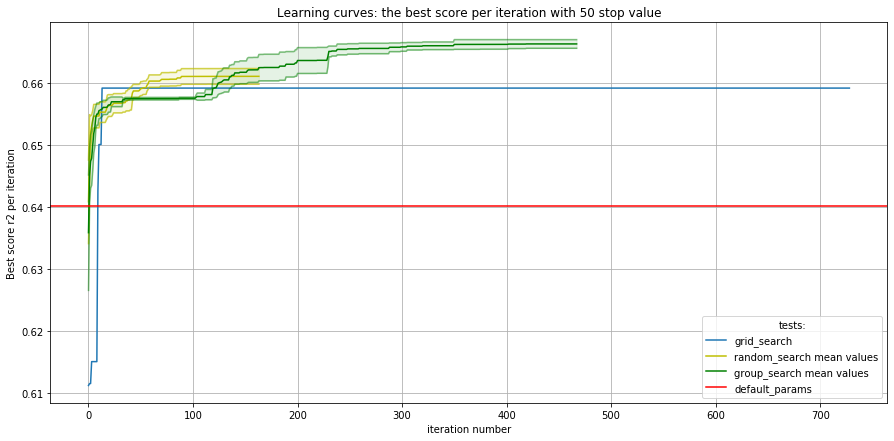

In [103]:
# Data with stop criterion
# stop if the cumulative score hasn't grown in "stop_iter_num" iterations
# GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params',
                      'mean_test_score'].cummax()


## RANDOM_SEARCH
# get best scores per itration for each random_search performance:
# random_df_stopped
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=random_df_stopped.shape[0]/random_df_stopped.iter_num.max() # now n=9, because 4 runs were made for random search
random_std=random_df_stopped.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std*z)/np.sqrt(n) #confidence interval value 
random_mean=random_df_stopped.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):

n=full_df.shape[0]/full_df.iter_num.max() # now n=10
group_std=full_df.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_std=group_std.fillna(0)
group_mean=full_df.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=grid_df.loc[grid_df['experiment_name']=='default params', 'mean_test_score']


## PLOT
plt.figure(figsize=(15,7))
plt.grid()

#grid plot:
x=list(range(0, grid_perf.shape[0]))
plt.plot(x, grid_perf, label="grid_search")

#conf for random:
x=list(range(0, random_mean.shape[0]))
plt.plot(x, random_mean, color="y", label="random_search mean values")
lower_random=random_mean - random_std
upper_random=random_mean + random_std
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 

#conf for group:
x=list(range(0, group_mean.shape[0]))
plt.plot(x, group_mean, color="green", label="group_search mean values")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf.values, label="default_params", color='r')

plt.legend(title='tests:')
plt.title("Learning curves: the best score per iteration with {} stop value".format(stop_iter_num))
plt.ylabel("Best score r2 per iteration")
plt.xlabel("iteration number")
plt.savefig("../graphs/test 2/scores_with_stop_{}.jpg".format(stop_iter_num))
plt.show()

In [104]:
df = pd.concat([full_df, random_df_stopped], sort = False)

In [105]:
best_scores=df.groupby(by=['experiment_name', 
                           'run_number'])['mean_test_score'].max().reset_index()
#print("best scores:")
#print(best_scores)

best=pd.merge(df, best_scores, how='inner', 
              on=['experiment_name','run_number','mean_test_score']
             ).loc[:,['experiment_name','mean_test_score', 
                      'iter_num','run_number']]
#best step and params

In [106]:
best_scores_grpBy = best_scores.groupby(by='experiment_name')['mean_test_score']

In [107]:
print("MEAN:")
print(best_scores_grpBy.mean())
print("STD:")
print(best_scores_grpBy.std())

MEAN:
experiment_name
group search     0.666308
random search    0.661082
Name: mean_test_score, dtype: float64
STD:
experiment_name
group search     0.001121
random search    0.002038
Name: mean_test_score, dtype: float64


In [108]:
stats = best_scores_grpBy.agg([np.mean,np.std]).loc['random search']

In [109]:
scores_info['RS_'+str(stop_iter_num)] = {'mean':stats['mean'], 
                                         'std': stats['std']}

In [110]:
iters_info

{'GRS_100': {'mean': 460.1, 'std': 52.29235125713893},
 'RS_100': {'mean': 195.0, 'std': 48.20165972246184},
 'GRS_75': {'mean': 419.4, 'std': 72.4599199557935},
 'RS_75': {'mean': 162.3, 'std': 33.41870733586205},
 'GRS_50': {'mean': 298.8, 'std': 76.77343290487927},
 'RS_50': {'mean': 106.5, 'std': 32.47537528651517}}

In [111]:
with open("../data/results/test 2/iters_info.txt", 'w') as outfile:
    json.dump(iters_info, outfile)

In [112]:
scores_info

{'GRS_100': {'mean': 0.6674590799006869, 'std': 0.0010305259879038954},
 'RS_100': {'mean': 0.6627090283296673, 'std': 0.002200474470596113},
 'GRS_75': {'mean': 0.6673347659686246, 'std': 0.001143914437668295},
 'RS_75': {'mean': 0.6624504569887075, 'std': 0.002053794666269355},
 'GRS_50': {'mean': 0.6663082716758508, 'std': 0.0010631944516123837},
 'RS_50': {'mean': 0.6610820315997675, 'std': 0.0020377103949608287}}

In [113]:
with open("../data/results/test 2/scores_info.txt", 'w') as outfile:
    json.dump(scores_info, outfile)